# Import Packages and functions

C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\FunctionsAndClass.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


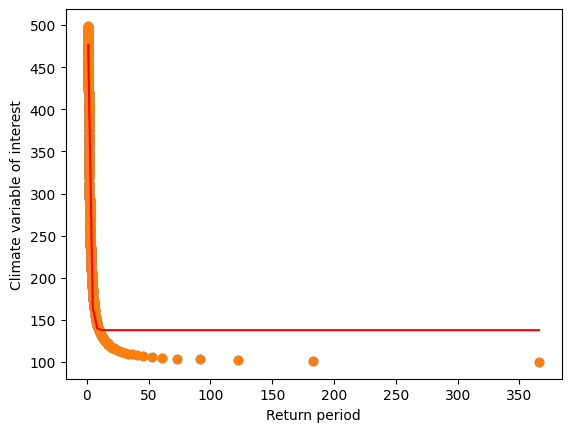

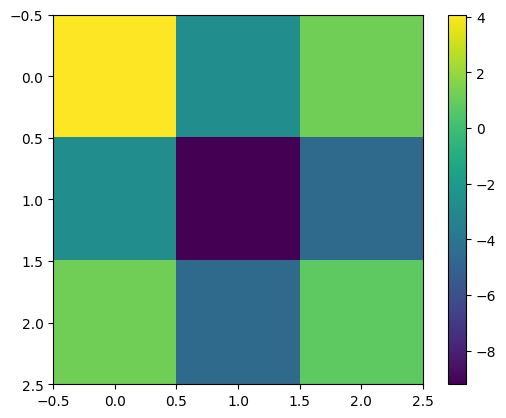

In [1]:
import requests
import pandas as pd

import os
import os.path

from netCDF4 import Dataset


import numpy as np
import numpy.ma as ma

# to measure elapsed time
import time
from timeit import default_timer as timer

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

from FileManagement1 import produce_name_list
from FunctionsAndClass import year_copernicus
from FileManagement1 import find_path_file
from FileManagement1 import find_column_name
from FileManagement1 import data_information
from FileManagement1 import df_to_csv
from FileManagement1 import read_nc_file
from FileManagement1 import information_files_in_vectors
from FileManagement1 import create_empty_dataframe
from FileManagement1 import _lat_lon
from FileManagement1 import register_data_in_dataframe
from FileManagement1 import closest_lat_lon_to_proj

# Projects information


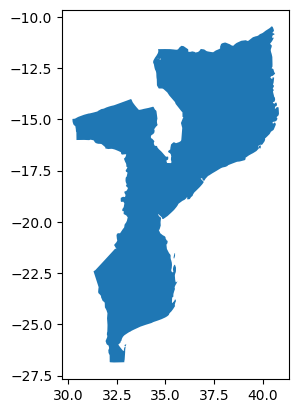

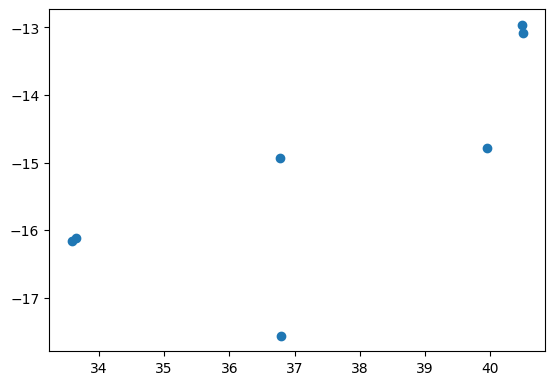

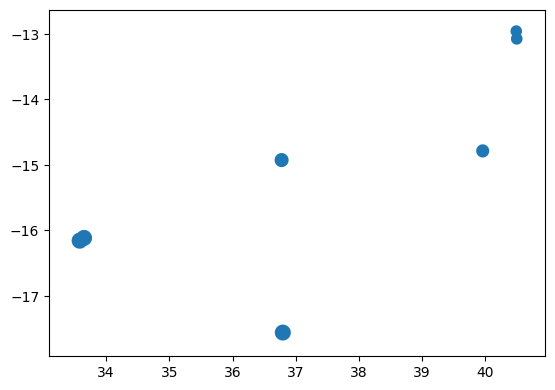

In [2]:
import geopandas as gpd
import os
import os.path

data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')


#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
project_id='Name' #name of column used as id

study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]
# prepare name_project for use 
name_project = projects['Name'].str.replace(' ','_') # take off every blank space of project names
name_project = name_project.str.replace('(','') # take off every ( of project names
name_project = name_project.str.replace(')','') # take off every ) of project names
name_project = name_project.str.replace('-','') # take off every - of project names
name_project = name_project.str.replace('/','_') # take off every / of project names
name_project = name_project.str.replace(r'"\"','_') # take off every \ of project names

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
buf_projects = 0.3
area_projects = [lat_projects - buf_projects, lat_projects+buf_projects, lon_projects-buf_projects,lon_projects+buf_projects] # list format
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

# Define Paths

In [3]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6'

# Complete list of url with files to download

In [4]:
# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)

In [5]:
### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]

In [6]:
## download only precipitation data
# select only precipitation files, between 2040 and 2080
url_list_precipitation = [url for url in url_list if 'pr_day_' in url and int(url[len(url)-7:len(url)-3])>2020 and int(url[len(url)-7:len(url)-3])<2061 and 'r1i1p1f1_gn' in url]

In [7]:
len(url_list_precipitation)

2360

In [8]:
name_list_precipitation = produce_name_list(url_list_precipitation)

# Produce csv files with data to use

In [9]:
start_year = 2021
stop_year = 2060
(year, year_str, index_year) = year_copernicus(start_year,stop_year)
time = pd.date_range('01-01-2021','31-12-2060', freq='D').strftime('%d-%m-%Y').values 

In [10]:
# variables, time_aggregations,models,scenarios in the name_list_precipitation
(variables, time_aggregations,models,scenarios)=information_files_in_vectors(name_list_precipitation)

In [11]:
if 'pr_day_UKESM1-0-LL_ssp126_r1i1p1f2_gn_2023.nc' in name_list_precipitation:
    print('chouette') # normal, ce n'est pas le bon ensemble

In [12]:
path_test1 = os.path.join(out_path,'pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc')

In [13]:
(index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon)=_lat_lon(path_test1,lat_projects,lon_projects)

In [14]:
df_precipitation=create_empty_dataframe(name_project,scenarios,models,time,closest_value_lat,closest_value_lon)

In [15]:
df_precipitation

Longitude  \
                                                                   33.625   
Name project          Experiment Model      Date       Latitude             
PT_Revubue_2_Rev_2_01 ssp245     ACCESS-CM2 01-01-2021 -16.125        NaN   
                                            02-01-2021 -16.125        NaN   
                                            03-01-2021 -16.125        NaN   
                                            04-01-2021 -16.125        NaN   
                                            05-01-2021 -16.125        NaN   
...                                                                   ...   
PT__Dumping_Site      ssp370     TaiESM1    27-12-2060 -13.125        NaN   
                                            28-12-2060 -13.125        NaN   
                                            29-12-2060 -13.125        NaN   
                                            30-12-2060 -13.125        NaN   
                                            31-12-2060 -13.125        NaN   

                                                                               \
                                                                39.875 36.875   
Name project          Experiment Model      Date       Latitude                 
PT_Revubue_2_Rev_2_01 ssp245     ACCESS-CM2 01-01-2021 -16.125     NaN    NaN   
                                            02-01-2021 -16.125     NaN    NaN   
                                            03-01-2021 -16.125     NaN    NaN   
                                            04-01-2021 -16.125     NaN    NaN   
                                            05-01-2021 -16.125     NaN    NaN   
...                                                                ...    ...   
PT__Dumping_Site      ssp370     TaiESM1    27-12-2060 -13.125     NaN    NaN   
                                            28-12-2060 -13.125     NaN    NaN   
                                            29-12-2060 -13.125     NaN    NaN   
                                            30-12-2060 -13.125     NaN    NaN   
                                            31-12-2060 -13.125     NaN    NaN   

                                                                        
                                                                40.375  
Name project          Experiment Model      Date       Latitude         
PT_Revubue_2_Rev_2_01 ssp245     ACCESS-CM2 01-01-2021 -16.125     NaN  
                                            02-01-2021 -16.125     NaN  
                                            03-01-2021 -16.125     NaN  
                                            04-01-2021 -16.125     NaN  
                                            05-01-2021 -16.125     NaN  
...                                                                ...  
PT__Dumping_Site      ssp370     TaiESM1    27-12-2060 -13.125     NaN  
                                            28-12-2060 -13.125     NaN  
                                            29-12-2060 -13.125     NaN  
                                            30-12-2060 -13.125     NaN  
                                            31-12-2060 -13.125     NaN  

[6136200 rows x 4 columns]

In [16]:
time_aggregations[0]

'day'

In [17]:
models

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CanESM5',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'IITM-ESM',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1']

In [18]:
# commencer a 6h30

In [ ]:
name_variable= 'pr'
df_precipitation=register_data_in_dataframe(name_list_precipitation,time_aggregations[0],year_str,scenarios,models,out_path, name_variable, name_project,lon_projects,lat_projects,index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon,df_precipitation)

For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model

For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3
[]
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2021.nc']
For the year 2021 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2021.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2022.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2022

For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3

For the year 2023 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model

For the year 2024 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2024.nc']
For the year 2024 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2024.nc']
For the year 2024 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2024.nc']
For the year 2024 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2024.nc']
For the year 2024 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2024.nc']
For the year 2024 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2024.nc']
For the year 2024 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_

For the year 2025 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2025.nc']
For the year 2025 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2025.nc']
For the year 2025 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2025.nc']
For the year 2025 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2025.nc']
For the year 2025 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2025.nc']
For the year 2025 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2025.nc']
For the year 2025 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3

For the year 2026 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2026.nc']
For the year 2026 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2026.nc']
For the year 2026 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2026.nc']
For the year 2026 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2026.nc']
For the year 2026 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2026.nc']
For the year 2026 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2026.nc']
For the year 2026 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model

For the year 2027 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2027.nc']
For the year 2027 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2027.nc']
For the year 2027 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2027.nc']
For the year 2027 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2027.nc']
For the year 2027 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2027.nc']
For the year 2027 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2027.nc']
For the year 2027 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_

For the year 2028 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2028.nc']
For the year 2028 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2028.nc']
For the year 2028 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2028.nc']
For the year 2028 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2028.nc']
For the year 2028 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2028.nc']
For the year 2028 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2028.nc']
For the year 2028 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NESM3

For the year 2029 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2029.nc']
For the year 2029 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2029.nc']
For the year 2029 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2029.nc']
For the year 2029 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2029.nc']
For the year 2029 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2029.nc']
For the year 2029 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2029.nc']
For the year 2029 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model

For the year 2030 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2030.nc']
For the year 2030 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_

For the year 2031 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NESM3

For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model

For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3
[]
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2032.nc']
For the year 2032 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2032.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2033.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2033

For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3

For the year 2034 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model

For the year 2035 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2035.nc']
For the year 2035 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_

For the year 2036 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3

For the year 2037 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2037.nc']
For the year 2037 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2037.nc']
For the year 2037 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2037.nc']
For the year 2037 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2037.nc']
For the year 2037 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2037.nc']
For the year 2037 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2037.nc']
For the year 2037 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model

For the year 2038 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2038.nc']
For the year 2038 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_

For the year 2039 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NESM3

For the year 2040 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model

For the year 2041 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2041.nc']
For the year 2041 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2041.nc']
For the year 2041 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2041.nc']
For the year 2041 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2041.nc']
For the year 2041 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2041.nc']
For the year 2041 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2041.nc']
For the year 2041 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_

For the year 2042 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2042.nc']
For the year 2042 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2042.nc']
For the year 2042 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2042.nc']
For the year 2042 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2042.nc']
For the year 2042 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2042.nc']
For the year 2042 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2042.nc']
For the year 2042 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NESM3

For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model

For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3
[]
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2043.nc']
For the year 2043 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2043.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2044.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2044

For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2044.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2044.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2044.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2044.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2044.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2044.nc']
For the year 2044 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3

For the year 2045 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2045.nc']
For the year 2045 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2045.nc']
For the year 2045 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2045.nc']
For the year 2045 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2045.nc']
For the year 2045 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2045.nc']
For the year 2045 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2045.nc']
For the year 2045 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model

For the year 2046 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2046.nc']
For the year 2046 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_

For the year 2047 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3

For the year 2048 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model

For the year 2049 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2049.nc']
For the year 2049 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_

For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NESM3

For the year 2051 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model

For the year 2052 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2052.nc']
For the year 2052 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2052.nc']
For the year 2052 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2052.nc']
For the year 2052 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2052.nc']
For the year 2052 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2052.nc']
For the year 2052 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2052.nc']
For the year 2052 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_

For the year 2053 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2053.nc']
For the year 2053 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2053.nc']
For the year 2053 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2053.nc']
For the year 2053 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2053.nc']
For the year 2053 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2053.nc']
For the year 2053 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2053.nc']
For the year 2053 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model NESM3

For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model

For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3
[]
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2054.nc']
For the year 2054 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2054.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2055.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2055

For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2055.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2055.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2055.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2055.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2055.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2055.nc']
For the year 2055 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model NESM3

For the year 2056 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2056.nc']
For the year 2056 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2056.nc']
For the year 2056 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2056.nc']
For the year 2056 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2056.nc']
For the year 2056 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2056.nc']
For the year 2056 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2056.nc']
For the year 2056 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model

For the year 2057 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2057.nc']
For the year 2057 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2057.nc']
For the year 2057 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2057.nc']
For the year 2057 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2057.nc']
For the year 2057 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2057.nc']
For the year 2057 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2057.nc']
For the year 2057 and project PT_Revubue_2_Rev_2_01, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_

For the year 2058 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2058.nc']
For the year 2058 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2058.nc']
For the year 2058 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2058.nc']
For the year 2058 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2058.nc']
For the year 2058 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2058.nc']
For the year 2058 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2058.nc']
For the year 2058 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model NESM3

For the year 2059 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2059.nc']
For the year 2059 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2059.nc']
For the year 2059 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2059.nc']
For the year 2059 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2059.nc']
For the year 2059 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2059.nc']
For the year 2059 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2059.nc']
For the year 2059 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model

For the year 2060 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2060.nc']
For the year 2060 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2060.nc']
For the year 2060 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2060.nc']
For the year 2060 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2060.nc']
For the year 2060 and project PT_Revubue_2_Rev_2_01, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2060.nc']
For the year 2060 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2060.nc']
For the year 2060 and project PT_Revubue_2_Rev_2_01, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_

For the year 2021 and project WTP_gate_cnr1, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2021.nc']
For the year 2021 and project WTP_gate_cnr1, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2021.nc']
For the year 2021 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2021.nc']
For the year 2021 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2021.nc']
For the year 2021 and project WTP_gate_cnr1, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2021.nc']
For the year 2021 and project WTP_gate_cnr1, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2021.nc']
For the year 2021 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2021.nc']
For the y

For the year 2022 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2022.nc']
For the year 2022 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2022.nc']
For the year 2022 and project WTP_gate_cnr1, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2022.nc']
For the year 2022 and project WTP_gate_cnr1, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2022.nc']
For the year 2022 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2022.nc']
For the year 2022 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2022.nc']
For the year 2022 and project WTP_gate_cnr1, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2022.nc

For the year 2023 and project WTP_gate_cnr1, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2023.nc']
For the year 2023 and project WTP_gate_cnr1, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2023.nc']
For the year 2023 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2023.nc']
For the year 2023 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2023.nc']
For the year 2023 and project WTP_gate_cnr1, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2023.nc']
For the year 2023 and project WTP_gate_cnr1, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2023.nc']
For the year 2023 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2023.nc']
For the

For the year 2024 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2024.nc']
For the year 2024 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2024.nc']
For the year 2024 and project WTP_gate_cnr1, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2024.nc']
For the year 2024 and project WTP_gate_cnr1, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2024.nc']
For the year 2024 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2024.nc']
For the year 2024 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2024.nc']
For the year 2024 and project WTP_gate_cnr1, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2024.nc']

For the year 2025 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2025.nc']
For the year 2025 and project WTP_gate_cnr1, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2025.nc']
For the year 2025 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2025.nc']
For the year 2025 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2025.nc']
For the year 2025 and project WTP_gate_cnr1, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2025.nc']
For the year 2025 and project WTP_gate_cnr1, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2025.nc']
For the year 2025 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2025.nc']

For the year 2026 and project WTP_gate_cnr1, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2026.nc']
For the year 2026 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2026.nc']
For the year 2026 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2026.nc']
For the year 2026 and project WTP_gate_cnr1, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2026.nc']
For the year 2026 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2026.nc']
For the year 2026 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2026.nc']
For the year 2026 and project WTP_gate_cnr1, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2026.nc']
For the

For the year 2027 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2027.nc']
For the year 2027 and project WTP_gate_cnr1, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2027.nc']
For the year 2027 and project WTP_gate_cnr1, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2027.nc']
For the year 2027 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2027.nc']
For the year 2027 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2027.nc']
For the year 2027 and project WTP_gate_cnr1, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2027.nc']
For the year 2027 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2027.nc']
For the y

For the year 2028 and project WTP_gate_cnr1, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2028.nc']
For the year 2028 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2028.nc']
For the year 2028 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2028.nc']
For the year 2028 and project WTP_gate_cnr1, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2028.nc']
For the year 2028 and project WTP_gate_cnr1, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2028.nc']
For the year 2028 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2028.nc']
For the year 2028 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2028.nc']
For t

For the year 2029 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2029.nc']
For the year 2029 and project WTP_gate_cnr1, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2029.nc']
For the year 2029 and project WTP_gate_cnr1, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2029.nc']
For the year 2029 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2029.nc']
For the year 2029 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2029.nc']
For the year 2029 and project WTP_gate_cnr1, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2029.nc']
For the year 2029 and project WTP_gate_cnr1, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2029.nc']
For the yea

For the year 2030 and project WTP_gate_cnr1, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project WTP_gate_cnr1, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project WTP_gate_cnr1, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2030.nc']
For the year 2030 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2030.nc']
For

For the year 2031 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project WTP_gate_cnr1, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project WTP_gate_cnr1, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project WTP_gate_cnr1, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2031.nc']
For the year 2031 and project WTP_gate_cnr1, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2031.nc']
For the

For the year 2031 and project WTP_gate_cnr1, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2031.nc']
For the year 2032 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project WTP_gate_cnr1, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project WTP_gate_cnr1, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2032.nc']
For the year 2032 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2032.nc']
F

For the year 2032 and project WTP_gate_cnr1, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2032.nc']
For the year 2032 and project WTP_gate_cnr1, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2032.nc']
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2033.nc']
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2033.nc']
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2033.nc']
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2033.nc']
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2033.nc']

For the year 2033 and project WTP_gate_cnr1, test with scenario ssp370, with model NESM3
[]
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2033 and project WTP_gate_cnr1, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2033.nc']
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2034.nc']
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2034.nc']
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2034.nc']
For the year 2034 and project WTP_gate_cnr1, tes

For the year 2034 and project WTP_gate_cnr1, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp370, with model NESM3
[]
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2034 and project WTP_gate_cnr1, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2034.nc']
For the year 2035 and project WTP_gate_cnr1, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2035.nc']
For the year 2035 and project WTP_gate_cnr1, test 

For the year 2035 and project WTP_gate_cnr1, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2035.nc']
For the year 2035 and project WTP_gate_cnr1, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2035.nc']
For the year 2035 and project WTP_gate_cnr1, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2035.nc']
For the year 2035 and project WTP_gate_cnr1, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2035.nc']
For the year 2035 and project WTP_gate_cnr1, test with scenario ssp370, with model NESM3
[]
For the year 2035 and project WTP_gate_cnr1, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2035.nc']
For the year 2035 and project WTP_gate_cnr1, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2035.nc']
For the year 2035 and project WTP_gate_cnr1, t

For the year 2036 and project WTP_gate_cnr1, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2036.nc']
For the year 2036 and project WTP_gate_cnr1, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2036.nc']
For the year 2036 and project WTP_gate_cnr1, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2036.nc']
For the year 2036 and project WTP_gate_cnr1, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2036.nc']
For the year 2036 and project WTP_gate_cnr1, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2036.nc']
For the year 2036 and project WTP_gate_cnr1, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2036.nc']
For the year 2036 and project WTP_gate_cnr1, test with scenario ssp370, with model NESM3
[]
For the year 2036 and project WTP_gate_cnr1, test wi

For the year 2037 and project WTP_gate_cnr1, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2037.nc']
For the year 2037 and project WTP_gate_cnr1, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2037.nc']
For the year 2037 and project WTP_gate_cnr1, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2037.nc']
For the year 2037 and project WTP_gate_cnr1, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2037.nc']
For the year 2037 and project WTP_gate_cnr1, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2037.nc']
For the year 2037 and project WTP_gate_cnr1, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2037.nc']
For the year 2037 and project WTP_gate_cnr1, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2037.nc']
For

For the year 2038 and project WTP_gate_cnr1, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2038.nc']
For the year 2038 and project WTP_gate_cnr1, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2038.nc']
For the year 2038 and project WTP_gate_cnr1, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2038.nc']
For the year 2038 and project WTP_gate_cnr1, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2038.nc']
For the year 2038 and project WTP_gate_cnr1, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2038.nc']
For the year 2038 and project WTP_gate_cnr1, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2038.nc']
For the year 2038 and project WTP_gate_cnr1, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2038.nc']
For the

For the year 2039 and project WTP_gate_cnr1, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2039.nc']
For the year 2039 and project WTP_gate_cnr1, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2039.nc']
For the year 2039 and project WTP_gate_cnr1, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2039.nc']
For the year 2039 and project WTP_gate_cnr1, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2039.nc']
For the year 2039 and project WTP_gate_cnr1, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2039.nc']
For the year 2039 and project WTP_gate_cnr1, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2039.nc']
For the year 2039 and project WTP_gate_cnr1, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2039.nc']
F

For the year 2040 and project WTP_gate_cnr1, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2040.nc']
For the year 2040 and project WTP_gate_cnr1, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2040.nc']
For the year 2040 and project WTP_gate_cnr1, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2040.nc']
For the year 2040 and project WTP_gate_cnr1, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2040.nc']
For the year 2040 and project WTP_gate_cnr1, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2040.nc']
For the year 2040 and project WTP_gate_cnr1, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2040.nc']
For the year 2040 and project WTP_gate_cnr1, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2040.nc']
For

For the year 2041 and project WTP_gate_cnr1, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2041.nc']
For the year 2041 and project WTP_gate_cnr1, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2041.nc']
For the year 2041 and project WTP_gate_cnr1, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2041.nc']
For the year 2041 and project WTP_gate_cnr1, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2041.nc']
For the year 2041 and project WTP_gate_cnr1, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2041.nc']
For the year 2041 and project WTP_gate_cnr1, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2041.nc']
For the year 2041 and project WTP_gate_cnr1, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2041.nc']
For the y

For the year 2042 and project WTP_gate_cnr1, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2042.nc']
For the year 2042 and project WTP_gate_cnr1, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2042.nc']
For the year 2042 and project WTP_gate_cnr1, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2042.nc']
For the year 2042 and project WTP_gate_cnr1, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2042.nc']
For the year 2042 and project WTP_gate_cnr1, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2042.nc']
For the year 2042 and project WTP_gate_cnr1, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2042.nc']
For the year 2042 and project WTP_gate_cnr1, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2042.nc']
For

For the year 2043 and project WTP_gate_cnr1, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2043.nc']
For the year 2043 and project WTP_gate_cnr1, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2043.nc']
For the year 2043 and project WTP_gate_cnr1, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2043.nc']
For the year 2043 and project WTP_gate_cnr1, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2043.nc']
For the year 2043 and project WTP_gate_cnr1, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2043.nc']
For the year 2043 and project WTP_gate_cnr1, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2043.nc']
For the year 2043 and project WTP_gate_cnr1, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2043.nc']
For the y

For the year 2044 and project WTP_gate_cnr1, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2044.nc']
For the year 2044 and project WTP_gate_cnr1, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2044.nc']
For the year 2044 and project WTP_gate_cnr1, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2044.nc']
For the year 2044 and project WTP_gate_cnr1, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2044.nc']
For the year 2044 and project WTP_gate_cnr1, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2044.nc']
For the year 2044 and project WTP_gate_cnr1, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2044.nc']
For the year 2044 and project WTP_gate_cnr1, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2044.nc

For the year 2045 and project WTP_gate_cnr1, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2045.nc']
For the year 2045 and project WTP_gate_cnr1, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2045.nc']
For the year 2045 and project WTP_gate_cnr1, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2045.nc']
For the year 2045 and project WTP_gate_cnr1, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2045.nc']
For the year 2045 and project WTP_gate_cnr1, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2045.nc']
For the year 2045 and project WTP_gate_cnr1, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2045.nc']
For the year 2045 and project WTP_gate_cnr1, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2045.nc']
For the

For the year 2046 and project WTP_gate_cnr1, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project WTP_gate_cnr1, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project WTP_gate_cnr1, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project WTP_gate_cnr1, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project WTP_gate_cnr1, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project WTP_gate_cnr1, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2046.nc']
For the year 2046 and project WTP_gate_cnr1, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2046.nc']

For the year 2047 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2047.nc']
For the year 2047 and project WTP_gate_cnr1, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2047.nc']
For the year 2047 and project WTP_gate_cnr1, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project WTP_gate_cnr1, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project WTP_gate_cnr1, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project WTP_gate_cnr1, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2047.nc']
For the year 2047 and project WTP_gate_cnr1, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2047.nc']

For the year 2048 and project WTP_gate_cnr1, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2048.nc']
For the year 2048 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2048.nc']
For the year 2048 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2048.nc']
For the year 2048 and project WTP_gate_cnr1, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2048.nc']
For the year 2048 and project WTP_gate_cnr1, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project WTP_gate_cnr1, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2048.nc']
For the year 2048 and project WTP_gate_cnr1, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2048.nc']
For the

For the year 2049 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project WTP_gate_cnr1, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project WTP_gate_cnr1, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project WTP_gate_cnr1, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2049.nc']
For the year 2049 and project WTP_gate_cnr1, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2049.nc']
For the y

For the year 2050 and project WTP_gate_cnr1, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project WTP_gate_cnr1, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project WTP_gate_cnr1, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2050.nc']
For the year 2050 and project WTP_gate_cnr1, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2050.nc']
For t

For the year 2051 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project WTP_gate_cnr1, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project WTP_gate_cnr1, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project WTP_gate_cnr1, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2051.nc']
For the year 2051 and project WTP_gate_cnr1, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2051.nc']
For the yea

For the year 2052 and project WTP_gate_cnr1, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2052.nc']
For the year 2052 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2052.nc']
For the year 2052 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2052.nc']
For the year 2052 and project WTP_gate_cnr1, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2052.nc']
For the year 2052 and project WTP_gate_cnr1, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2052.nc']
For the year 2052 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2052.nc']
For the year 2052 and project WTP_gate_cnr1, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2052.nc']
For

For the year 2053 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2053.nc']
For the year 2053 and project WTP_gate_cnr1, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2053.nc']
For the year 2053 and project WTP_gate_cnr1, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2053.nc']
For the year 2053 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2053.nc']
For the year 2053 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2053.nc']
For the year 2053 and project WTP_gate_cnr1, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2053.nc']
For the year 2053 and project WTP_gate_cnr1, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2053.nc']
For the

For the year 2054 and project WTP_gate_cnr1, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2054.nc']
For the year 2054 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2054.nc']
For the year 2054 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2054.nc']
For the year 2054 and project WTP_gate_cnr1, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2054.nc']
For the year 2054 and project WTP_gate_cnr1, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2054.nc']
For the year 2054 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2054.nc']
For the year 2054 and project WTP_gate_cnr1, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2054.nc']
F

For the year 2055 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2055.nc']
For the year 2055 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2055.nc']
For the year 2055 and project WTP_gate_cnr1, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2055.nc']
For the year 2055 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2055.nc']
For the year 2055 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2055.nc']
For the year 2055 and project WTP_gate_cnr1, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2055.nc']
For the year 2055 and project WTP_gate_cnr1, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2055.nc']
For

For the year 2056 and project WTP_gate_cnr1, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2056.nc']
For the year 2056 and project WTP_gate_cnr1, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2056.nc']
For the year 2056 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2056.nc']
For the year 2056 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2056.nc']
For the year 2056 and project WTP_gate_cnr1, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2056.nc']
For the year 2056 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2056.nc']
For the year 2056 and project WTP_gate_cnr1, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2056.nc']
For the y

For the year 2057 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2057.nc']
For the year 2057 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2057.nc']
For the year 2057 and project WTP_gate_cnr1, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2057.nc']
For the year 2057 and project WTP_gate_cnr1, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2057.nc']
For the year 2057 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2057.nc']
For the year 2057 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2057.nc']
For the year 2057 and project WTP_gate_cnr1, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2057.nc']
For

For the year 2058 and project WTP_gate_cnr1, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2058.nc']
For the year 2058 and project WTP_gate_cnr1, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2058.nc']
For the year 2058 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2058.nc']
For the year 2058 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2058.nc']
For the year 2058 and project WTP_gate_cnr1, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2058.nc']
For the year 2058 and project WTP_gate_cnr1, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2058.nc']
For the year 2058 and project WTP_gate_cnr1, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2058.nc']
For the y

For the year 2059 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2059.nc']
For the year 2059 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2059.nc']
For the year 2059 and project WTP_gate_cnr1, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2059.nc']
For the year 2059 and project WTP_gate_cnr1, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2059.nc']
For the year 2059 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2059.nc']
For the year 2059 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2059.nc']
For the year 2059 and project WTP_gate_cnr1, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2059.nc

For the year 2060 and project WTP_gate_cnr1, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2060.nc']
For the year 2060 and project WTP_gate_cnr1, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2060.nc']
For the year 2060 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2060.nc']
For the year 2060 and project WTP_gate_cnr1, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2060.nc']
For the year 2060 and project WTP_gate_cnr1, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2060.nc']
For the year 2060 and project WTP_gate_cnr1, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2060.nc']
For the year 2060 and project WTP_gate_cnr1, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2060.nc']
For the

For the year 2021 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project Mugica_dam_road, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project Mugica_dam_road, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2021.nc']
For the year 2021 and project Mugica_dam_road, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f

For the year 2021 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2021.nc']
For the year 2021 and project Mugica_dam_road, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2021.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2022.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2022.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2022.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2022.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f

For the year 2022 and project Mugica_dam_road, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp370, with model NESM3
[]
For the year 2022 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2022 and project Mugica_dam_road, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2022.nc']
For the year 2023 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2023.nc']
For the year 2023 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2023.nc']
For the year 2023 and project Mugica

For the year 2023 and project Mugica_dam_road, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project Mugica_dam_road, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project Mugica_dam_road, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project Mugica_dam_road, test with scenario ssp370, with model NESM3
[]
For the year 2023 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2023 and project Mugica_dam_road, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2023.nc']
For the year 2024 and project 

For the year 2024 and project Mugica_dam_road, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2024.nc']
For the year 2024 and project Mugica_dam_road, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2024.nc']
For the year 2024 and project Mugica_dam_road, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2024.nc']
For the year 2024 and project Mugica_dam_road, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2024.nc']
For the year 2024 and project Mugica_dam_road, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p1f1_gn_2024.nc']
For the year 2024 and project Mugica_dam_road, test with scenario ssp370, with model NESM3
[]
For the year 2024 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2024.nc']
For the year 2024 and project Mugica

For the year 2025 and project Mugica_dam_road, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2025.nc']
For the year 2025 and project Mugica_dam_road, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2025.nc']
For the year 2025 and project Mugica_dam_road, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2025.nc']
For the year 2025 and project Mugica_dam_road, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2025.nc']
For the year 2025 and project Mugica_dam_road, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_2025.nc']
For the year 2025 and project Mugica_dam_road, test with scenario ssp370, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp370_r1i1p1f1_gn_2025.nc']
For the year 2025 and project Mugica_dam_road, test with scenario ssp370, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp370_r1i1p

For the year 2026 and project Mugica_dam_road, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2026.nc']
For the year 2026 and project Mugica_dam_road, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2026.nc']
For the year 2026 and project Mugica_dam_road, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2026.nc']
For the year 2026 and project Mugica_dam_road, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2026.nc']
For the year 2026 and project Mugica_dam_road, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f1_gn_2026.nc']
For the year 2026 and project Mugica_dam_road, test with scenario ssp370, with model MIROC6
['pr_day_MIROC6_ssp370_r1i1p1f1_gn_2026.nc']
For the year 2026 and project Mugica_dam_road, test with scenario ssp370, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp370_r1i1p1f1_gn_202

For the year 2027 and project Mugica_dam_road, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2027.nc']
For the year 2027 and project Mugica_dam_road, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2027.nc']
For the year 2027 and project Mugica_dam_road, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2027.nc']
For the year 2027 and project Mugica_dam_road, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2027.nc']
For the year 2027 and project Mugica_dam_road, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f1_gn_2027.nc']
For the year 2027 and project Mugica_dam_road, test with scenario ssp370, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp370_r1i1p1f1_gn_2027.nc']
For the year 2027 and project Mugica_dam_road, test with scenario ssp370, with model IITM-ESM
['pr_day_IITM-ESM_ssp370_r1i1p1f

For the year 2028 and project Mugica_dam_road, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2028.nc']
For the year 2028 and project Mugica_dam_road, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2028.nc']
For the year 2028 and project Mugica_dam_road, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2028.nc']
For the year 2028 and project Mugica_dam_road, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2028.nc']
For the year 2028 and project Mugica_dam_road, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_2028.nc']
For the year 2028 and project Mugica_dam_road, test with scenario ssp370, with model CanESM5
['pr_day_CanESM5_ssp370_r1i1p1f1_gn_2028.nc']
For the year 2028 and project Mugica_dam_road, test with scenario ssp370, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp370_r1i1p1f

For the year 2029 and project Mugica_dam_road, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2029.nc']
For the year 2029 and project Mugica_dam_road, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2029.nc']
For the year 2029 and project Mugica_dam_road, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2029.nc']
For the year 2029 and project Mugica_dam_road, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2029.nc']
For the year 2029 and project Mugica_dam_road, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2029.nc']
For the year 2029 and project Mugica_dam_road, test with scenario ssp370, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2029.nc']
For the year 2029 and project Mugica_dam_road, test with scenario ssp370, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_202

For the year 2030 and project Mugica_dam_road, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2030.nc']
For the year 2030 and project Mugica_dam_road, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2030.nc']
For the year 2030 and project Mugica_dam_road, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2030.nc']
For the year 2030 and project Mugica_dam_road, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2030.nc']
For the year 2030 and project Mugica_dam_road, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2030.nc']
For the year 2030 and project Mugica_dam_road, test with scenario ssp126, with model TaiESM1
['pr_day_TaiESM1_ssp126_r1i1p1f1_gn_2030.nc']
For the year 2030 and project Mugica_dam_road, test with scenario ssp370, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp370_r1i1p1f1_gn_2030.

For the year 2031 and project Mugica_dam_road, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2031.nc']
For the year 2031 and project Mugica_dam_road, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2031.nc']
For the year 2031 and project Mugica_dam_road, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2031.nc']
For the year 2031 and project Mugica_dam_road, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2031.nc']
For the year 2031 and project Mugica_dam_road, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2031.nc']
For the year 2031 and project Mugica_dam_road, test with scenario ssp126, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp126_r1i1p1f1_gn_2031.nc']
For the year 2031 and project Mugica_dam_road, test with scenario ssp126, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp126_r1i1p1f1_gn_2

For the year 2032 and project Mugica_dam_road, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2032.nc']
For the year 2032 and project Mugica_dam_road, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2032.nc']
For the year 2032 and project Mugica_dam_road, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2032.nc']
For the year 2032 and project Mugica_dam_road, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2032.nc']
For the year 2032 and project Mugica_dam_road, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_2032.nc']
For the year 2032 and project Mugica_dam_road, test with scenario ssp126, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp126_r1i1p1f1_gn_2032.nc']
For the year 2032 and project Mugica_dam_road, test with scenario ssp126, with model NESM3
['pr_day_NESM3_ssp126_r1i1p1f1_gn_2032.nc

For the year 2033 and project Mugica_dam_road, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2033.nc']
For the year 2033 and project Mugica_dam_road, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2033.nc']
For the year 2033 and project Mugica_dam_road, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2033.nc']
For the year 2033 and project Mugica_dam_road, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2033.nc']
For the year 2033 and project Mugica_dam_road, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_2033.nc']
For the year 2033 and project Mugica_dam_road, test with scenario ssp126, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_2033.nc']
For the year 2033 and project Mugica_dam_road, test with scenario ssp126, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn

For the year 2034 and project Mugica_dam_road, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2034.nc']
For the year 2034 and project Mugica_dam_road, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2034.nc']
For the year 2034 and project Mugica_dam_road, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2034.nc']
For the year 2034 and project Mugica_dam_road, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2034.nc']
For the year 2034 and project Mugica_dam_road, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_gn_2034.nc']
For the year 2034 and project Mugica_dam_road, test with scenario ssp126, with model IITM-ESM
['pr_day_IITM-ESM_ssp126_r1i1p1f1_gn_2034.nc']
For the year 2034 and project Mugica_dam_road, test with scenario ssp126, with model MIROC6
['pr_day_MIROC6_ssp126_r1i1p1f1_gn_203

For the year 2035 and project Mugica_dam_road, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2035.nc']
For the year 2035 and project Mugica_dam_road, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project Mugica_dam_road, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project Mugica_dam_road, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project Mugica_dam_road, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project Mugica_dam_road, test with scenario ssp126, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp126_r1i1p1f1_gn_2035.nc']
For the year 2035 and project Mugica_dam_road, test with scenario ssp126, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp126_r1i1p1f1_

For the year 2036 and project Mugica_dam_road, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2036.nc']
For the year 2036 and project Mugica_dam_road, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2036.nc']
For the year 2036 and project Mugica_dam_road, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2036.nc']
For the year 2036 and project Mugica_dam_road, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project Mugica_dam_road, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project Mugica_dam_road, test with scenario ssp126, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_2036.nc']
For the year 2036 and project Mugica_dam_road, test with scenario ssp126, with model CanESM5
['pr_day_CanESM5_ssp126_r1i1p1f1_gn

For the year 2037 and project Mugica_dam_road, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2037.nc']
For the year 2037 and project Mugica_dam_road, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2037.nc']
For the year 2037 and project Mugica_dam_road, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2037.nc']
For the year 2037 and project Mugica_dam_road, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2037.nc']
For the year 2037 and project Mugica_dam_road, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn_2037.nc']
For the year 2037 and project Mugica_dam_road, test with scenario ssp126, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2037.nc']
For the year 2037 and project Mugica_dam_road, test with scenario ssp126, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp126_r1i1p1f1_gn_2037.

For the year 2038 and project Mugica_dam_road, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project Mugica_dam_road, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project Mugica_dam_road, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project Mugica_dam_road, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project Mugica_dam_road, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project Mugica_dam_road, test with scenario ssp585, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp585_r1i1p1f1_gn_2038.nc']
For the year 2038 and project Mugica_dam_road, test with scenario ssp585, with model TaiESM1
['pr_day_TaiESM1_ssp585_r1i1p1f1_gn

For the year 2039 and project Mugica_dam_road, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project Mugica_dam_road, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project Mugica_dam_road, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project Mugica_dam_road, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project Mugica_dam_road, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project Mugica_dam_road, test with scenario ssp585, with model NESM3
['pr_day_NESM3_ssp585_r1i1p1f1_gn_2039.nc']
For the year 2039 and project Mugica_dam_road, test with scenario ssp585, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp585_r1i1p1f1_gn_2039.

For the year 2040 and project Mugica_dam_road, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project Mugica_dam_road, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project Mugica_dam_road, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project Mugica_dam_road, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project Mugica_dam_road, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project Mugica_dam_road, test with scenario ssp585, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2040.nc']
For the year 2040 and project Mugica_dam_road, test with scenario ssp585, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp585_r1i1p

For the year 2041 and project Mugica_dam_road, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2041.nc']
For the year 2041 and project Mugica_dam_road, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2041.nc']
For the year 2041 and project Mugica_dam_road, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2041.nc']
For the year 2041 and project Mugica_dam_road, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2041.nc']
For the year 2041 and project Mugica_dam_road, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f1_gn_2041.nc']
For the year 2041 and project Mugica_dam_road, test with scenario ssp585, with model MIROC6
['pr_day_MIROC6_ssp585_r1i1p1f1_gn_2041.nc']
For the year 2041 and project Mugica_dam_road, test with scenario ssp585, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_204

For the year 2042 and project Mugica_dam_road, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2042.nc']
For the year 2042 and project Mugica_dam_road, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2042.nc']
For the year 2042 and project Mugica_dam_road, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2042.nc']
For the year 2042 and project Mugica_dam_road, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2042.nc']
For the year 2042 and project Mugica_dam_road, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_gn_2042.nc']
For the year 2042 and project Mugica_dam_road, test with scenario ssp585, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_2042.nc']
For the year 2042 and project Mugica_dam_road, test with scenario ssp585, with model IITM-ESM
['pr_day_IITM-ESM_ssp585_r1i1p1f

For the year 2043 and project Mugica_dam_road, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project Mugica_dam_road, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2043.nc']
For the year 2043 and project Mugica_dam_road, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2043.nc']
For the year 2043 and project Mugica_dam_road, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2043.nc']
For the year 2043 and project Mugica_dam_road, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_2043.nc']
For the year 2043 and project Mugica_dam_road, test with scenario ssp585, with model CanESM5
['pr_day_CanESM5_ssp585_r1i1p1f1_gn_2043.nc']
For the year 2043 and project Mugica_dam_road, test with scenario ssp585, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp585_r1i1p1f

For the year 2044 and project Mugica_dam_road, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2044.nc']
For the year 2044 and project Mugica_dam_road, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2044.nc']
For the year 2044 and project Mugica_dam_road, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2044.nc']
For the year 2044 and project Mugica_dam_road, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2044.nc']
For the year 2044 and project Mugica_dam_road, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2044.nc']
For the year 2044 and project Mugica_dam_road, test with scenario ssp585, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_2044.nc']
For the year 2044 and project Mugica_dam_road, test with scenario ssp585, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_204

For the year 2045 and project Mugica_dam_road, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2045.nc']
For the year 2045 and project Mugica_dam_road, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2045.nc']
For the year 2045 and project Mugica_dam_road, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2045.nc']
For the year 2045 and project Mugica_dam_road, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2045.nc']
For the year 2045 and project Mugica_dam_road, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2045.nc']
For the year 2045 and project Mugica_dam_road, test with scenario ssp245, with model TaiESM1
['pr_day_TaiESM1_ssp245_r1i1p1f1_gn_2045.nc']
For the year 2045 and project Mugica_dam_road, test with scenario ssp585, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp585_r1i1p1f1_gn_2045.

For the year 2046 and project Mugica_dam_road, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2046.nc']
For the year 2046 and project Mugica_dam_road, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2046.nc']
For the year 2046 and project Mugica_dam_road, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2046.nc']
For the year 2046 and project Mugica_dam_road, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2046.nc']
For the year 2046 and project Mugica_dam_road, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2046.nc']
For the year 2046 and project Mugica_dam_road, test with scenario ssp245, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp245_r1i1p1f1_gn_2046.nc']
For the year 2046 and project Mugica_dam_road, test with scenario ssp245, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp245_r1i1p1f1_gn_2

For the year 2047 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2047.nc']
For the year 2047 and project Mugica_dam_road, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2047.nc']
For the year 2047 and project Mugica_dam_road, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2047.nc']
For the year 2047 and project Mugica_dam_road, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2047.nc']
For the year 2047 and project Mugica_dam_road, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2047.nc']
For the year 2047 and project Mugica_dam_road, test with scenario ssp245, with model MRI-ESM2-0
['pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2047.nc']
For the year 2047 and project Mugica_dam_road, test with scenario ssp245, with model NESM3
['pr_day_NESM3_ssp245_r1i1p1f1_gn_2047.nc

For the year 2048 and project Mugica_dam_road, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2048.nc']
For the year 2048 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2048.nc']
For the year 2048 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2048.nc']
For the year 2048 and project Mugica_dam_road, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2048.nc']
For the year 2048 and project Mugica_dam_road, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_2048.nc']
For the year 2048 and project Mugica_dam_road, test with scenario ssp245, with model MPI-ESM1-2-HR
['pr_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_2048.nc']
For the year 2048 and project Mugica_dam_road, test with scenario ssp245, with model MPI-ESM1-2-LR
['pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn

For the year 2049 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2049.nc']
For the year 2049 and project Mugica_dam_road, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2049.nc']
For the year 2049 and project Mugica_dam_road, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2049.nc']
For the year 2049 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2049.nc']
For the year 2049 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_gn_2049.nc']
For the year 2049 and project Mugica_dam_road, test with scenario ssp245, with model IITM-ESM
['pr_day_IITM-ESM_ssp245_r1i1p1f1_gn_2049.nc']
For the year 2049 and project Mugica_dam_road, test with scenario ssp245, with model MIROC6
['pr_day_MIROC6_ssp245_r1i1p1f1_gn_204

For the year 2049 and project Mugica_dam_road, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2049.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2050.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2050.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2050.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp245, with model CanESM5
['pr_day_CanESM5_ssp245_r1i1p1f1_gn_2050.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-CM2-SR5
['pr_day_CMCC-CM2-SR5_ssp245_r1i1p1f1_gn_2050.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp245, with model CMCC-ESM2
['pr_day_CMCC-ESM2_ssp245_r1i1p1f1_

For the year 2050 and project Mugica_dam_road, test with scenario ssp370, with model NESM3
[]
For the year 2050 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-LM
['pr_day_NorESM2-LM_ssp370_r1i1p1f1_gn_2050.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp370, with model NorESM2-MM
['pr_day_NorESM2-MM_ssp370_r1i1p1f1_gn_2050.nc']
For the year 2050 and project Mugica_dam_road, test with scenario ssp370, with model TaiESM1
['pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc']
For the year 2051 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-CM2
['pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_2051.nc']
For the year 2051 and project Mugica_dam_road, test with scenario ssp245, with model ACCESS-ESM1-5
['pr_day_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_2051.nc']
For the year 2051 and project Mugica_dam_road, test with scenario ssp245, with model BCC-CSM2-MR
['pr_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_2051.nc']
For the year 2051 and project Mugi

In [ ]:
title_file = 'All_projects_moz_precipitation_2021-2060.csv'
path_csv = df_to_csv(df_precipitation,out_path,title_file,name_variable,time_aggregations[0],'2021-2060')

In [ ]:
RuntimeError

In [ ]:
import xarray as xr
path_test1 = os.path.join(out_path,'pr_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_2025.nc')

ds =  xr.open_dataset(path_test1)
ds.pr.isel(lat=index_closest_lat[1],lon=index_closest_lon[1]).values

In [ ]:
index_closest_lat[0]

In [ ]:
index_closest_lon[0]

In [ ]:
type(ds.pr.isel(lat=175,lon=134))

In [ ]:
ds

In [ ]:
ds2

In [ ]:
ds2.pr.isel(lat=175,lon=134)

In [ ]:
import xarray as xr
path_test2 = os.path.join(out_path,'pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc')

ds2 =  xr.open_dataset(path_test2)
ds2.pr.isel(lat=index_closest_lat[0],lon=index_closest_lon[0]).values